#### 4번 노트북인 분산 DQN에 활용하는 update 수식, batch load 메소드, loss 적용 등등의 코드에 오류가 없는지 테스트하는 노트북입니다. <br>

    4에서 활용하고 있는 메소드는 변경하지 않고, 일반적인 single agent 클래스에서 network, buffer 등이 모두 들어가 있는 agent입니다.
    
    이 노트북은 굳이 실행하지 않아도 되지만, ray를 입힌 채로 알고리즘에 문제가 있는지 파악하려면 시간도 많이 걸리고 까다로운 부분이 있어서,
    우선 ray가 없이 순수 알고리즘만 테스트하는 노트북 파일을 별도로 만들었습니다.

In [1]:
import gym
import time 
import numpy as np 
from copy import deepcopy
import matplotlib.pyplot as plt
from IPython.display import clear_output

import wandb

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# Buffer를 정의합니다. 
class ReplayBuffer:
    def __init__(self, 
                   buffer_size: ('int: Buffer_size'), 
                 state_dim: ('tuple: State dim')):

        # 1차원 state라할지라도 tuple로 입력받도록 tuple 타입을 강제하였습니다. 
        # 밑에 줄의 self.buffer_dim을 구하기 위해서 이렇게 한 것인데요, 사실 빼도 상관없고 얼마든지 다르게 구현해도 무방합니다.
        # 참고) ray를 쓸 때는, class선언시에 assert조건을 만족못하여도 에러를 주지 않습니다. class의 메소드를 실행하고나서야 __init__에서 assertion 에러가 있다고 표시를 합니다. 
        assert type(state_dim) == tuple
        
        self.buffer_dim = (buffer_size, ) + state_dim
        self.buffer_size = buffer_size
        self.batch_update_status = True
        
        self.state_buffer = np.zeros(self.buffer_dim)
        self.action_buffer = np.zeros(buffer_size)
        self.reward_buffer = np.zeros(buffer_size)
        self.next_state_buffer = np.zeros(self.buffer_dim)
        self.done_buffer = np.zeros(buffer_size)
        self.act_idx_buffer = np.zeros(buffer_size)

        self.store_idx = 0
        self.current_size = 0
        self.total_store_count = 0

    def store(self, state, action, next_state, reward, done, actor_idx): 
        # actor_idx는 쓰이지 않지만, 중간에 데이터 저장이 잘 되는지 확인용 변수
        self.state_buffer[self.store_idx] = state
        self.action_buffer[self.store_idx] = action
        self.reward_buffer[self.store_idx] = reward
        self.next_state_buffer[self.store_idx] = next_state
        self.done_buffer[self.store_idx] = done
        self.act_idx_buffer[self.store_idx] = actor_idx
        
        self.total_store_count += 1 # used for counting the total number of steps during training
        self.store_idx = (self.store_idx + 1) % self.buffer_size
        self.current_size = min(self.current_size+1, self.buffer_size)
    
    def batch_load(self, batch_size): 
        indices = np.random.randint(self.current_size, size=batch_size)  
        return dict( 
                states=self.state_buffer[indices], 
                actions=self.action_buffer[indices], 
                rewards=self.reward_buffer[indices], 
                next_states=self.next_state_buffer[indices], 
                dones=self.done_buffer[indices],
                actindices=self.act_idx_buffer[indices])  
    
    # 아래의 메소드들은 ray로 다른 객체가 current_size, store_idx, total_store_count 변수들을 접근할 때 쓰기 위해서 선언
    def return_current_size(self):
        return self.current_size

    def return_store_idx(self):
        return self.store_idx

    def return_total_store_count(self):
        return self.total_store_count
    
    def batch_update_on(self):
        self.batch_update_status = True

    def batch_update_off(self):
        self.batch_update_status = False

    def return_batch_update_status(self):
        return self.batch_update_status
    
# # test
# buffer_size = 1000
# batch_size = 16
# state_dim = (4, )
# temp_buffer = ReplayBuffer.remote(buffer_size, state_dim)

# for i in range(50):
#     temp_buffer.store.remote(np.array(state_dim), 1, np.array(state_dim), 1, 1, 1)

# batch = temp_buffer.batch_load.remote(batch_size)
# print("Batch Size:", ray.get(batch)['actindices'].shape) 

# current_size = temp_buffer.return_current_size.remote()
# print("Current Size: ", ray.get(current_size))

# return_store_idx = temp_buffer.return_store_idx.remote()
# print("Store Index: ", ray.get(return_store_idx))

In [3]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden=32):
        super(QNetwork, self).__init__()

        state_size = state_size[0]
        self.fc1 = nn.Linear(state_size, hidden)
        self.fc2 = nn.Linear(hidden, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# state_size = (4, ) 
# action_size = 2 
# temp_net = QNetwork(state_size, action_size, 32) 
# test = torch.randn(size=(4,)) 
# temp_net(test), temp_net(test).shape 

In [4]:
class Network_parameter_server:
    def __init__(self): 
        self.is_saved = False # 언제부터 actor가 모델 parameter를 가지고 올 수 있는지 확인하는 변수
        
    def update_parameters(self, learner_params): 
        self.learner_params = learner_params
        self.is_saved = True

    def return_parameters(self):
        self.is_saved = False
        return self.learner_params
        
    def return_saving_status(self):
        return self.is_saved

In [5]:
# actor의 역할은 각각 env에서 경험한 것을 buffer에 넘겨주는 역할을 합니다.
class Actor:  
    def __init__(self, 
                 params_server: ("Class: Network parameter server"),
                 memory: ("class: Replay Buffer"),
                 env_name: ("str: Environment name"), 
                 actor_idx: ("int: The index of an actor"), 
                 gamma,
                 epsilon: ("int: starting epsilon value for e-greedy update"), 
                 eps_decay: ("int: epsilon decay rate"), 
                 eps_min: ("int: minimum epsilon value"), 
                 update_freq,
                 update_buf_start,
                 update_target_freq,
                 update_push_freq,
                 hidden: ("int: Update frequency of learner's q_behave network"), 
                 learning_rate,
                 batch_size,
                 device: ("int: Cuda device number"),
                 is_wandb: ("str: Whether wandb is on or off"),
                 plot_mode: ("str: whether to plot in wandb or inline in jupyter"),
                 WANDB_GROUP_NAME: ("str: Wandb's group name for all actors")):

        # wandb init config 
        if is_wandb:
            entity = 'rl_flip_school_team'  
            project_name = 'Distributed_DQN'
            wandb.init(
                    group=WANDB_GROUP_NAME,
                    project=project_name, 
                    entity=entity,
                    name=f'{actor_idx}_Distributed_DQN'
                    ) 

        self.env = gym.make(env_name)
        self.params_server = params_server
        self.memory = memory   # ray를 통해 공유하는 Replaybuffer class입니다.
        self.actor_idx = actor_idx # 어떤 actor에서 온 데이터인지 보기 위한 변수입니다.
        self.plot_mode = plot_mode
        self.device = device
        self.update_cnt = 0 # q_behave 업데이트 횟수
        self.update_freq = update_freq # q_behave 업데이트 주기
        self.update_buf_start = update_buf_start # 업데이트 시작 buffer size
        self.update_target_freq = update_target_freq # q_target 업데이트 주기
        self.update_push_freq = update_push_freq # parameter server에 보내는 주기
        self.gamma = gamma
        self.total_steps = 0
        self.scores = []
        self.frames = []
        self.losses = [0]
        self.batch_size = batch_size

        # DQN hyperparameters
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.eps_min = eps_min        

        # Network parameters
        self.state_dim = (self.env.observation_space.shape[0], )
        try: self.action_dim = self.env.action_space.n # Discrete action
        except: self.action_dim = env.action_space.shape[0] # Continous action            

        self.q_behave = QNetwork(self.state_dim, self.action_dim, hidden).to(self.device)
        self.q_target = QNetwork(self.state_dim, self.action_dim, hidden).to(self.device)
        self.q_target.load_state_dict(self.q_behave.state_dict())
        self.q_target.eval()

        self.optimizer = optim.Adam(self.q_behave.parameters(), lr=learning_rate) 

    def select_action(self, state): 
        # e-greedy로 action을 선택 
        if np.random.random() < self.epsilon: 
            return np.zeros(self.action_dim), self.env.action_space.sample() 
        else: 
            state = torch.FloatTensor(state).to(self.device).unsqueeze(0) 
            Qs = self.q_behave(state) 
            action = Qs.argmax() 
            return Qs.detach().cpu().numpy(), action.detach().item() 

    def push_parameters(self):
        # Send paramters to server 
        copied_model = deepcopy(self.q_behave).cpu()
        self.params_server.update_parameters(copied_model.state_dict())
        
    def train(self):
        score = 0
        state = self.env.reset()

        # actor는 멈추지 않고 무한 loop로 exploration하도록 설정
        while 1:
            Qs, action = self.select_action(state)
            next_state, reward, done, _ = self.env.step(action) 
            
            self.memory.store(state, action, next_state, reward, done, self.actor_idx) # 공유 ReplayBuffer에 저장
            self.update_q_network()

            score += reward
            state = next_state
            self.epsilon = max(self.epsilon-self.eps_decay, self.eps_min)
            if (self.update_cnt%self.update_target_freq)==0: self.target_hard_update()
            if done:
                self.scores.append(score)
                self.frames.append(self.memory.return_total_store_count())
                state = self.env.reset() 
                self._plot_inline()
                self._plot_status(score)
                score = 0

    def update_q_network(self):
        # update_cnt를 q_behave를 업데이트 할 때마다 1씩 상승 (self.update_target_freq 만큼 q_behave를 업데이트를 할 때마다 q_target을 업데이트 하기 위함)
        self.update_cnt += 1
        batch = self.memory.batch_load(self.batch_size) 
        loss = self._compute_loss(batch) 

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.losses.append(loss.item()) # for plotting the losses
        
    def target_hard_update(self):  
        # Hard update 방식
        self.q_target.load_state_dict(self.q_behave.state_dict()) 

    def _compute_loss(self, batch: "Dictionary (S, A, R', S', Dones)"):
        states = torch.FloatTensor(batch['states']).to(self.device)
        next_states = torch.FloatTensor(batch['next_states']).to(self.device)
        actions = torch.LongTensor(batch['actions'].reshape(-1, 1)).to(self.device)
        rewards = torch.FloatTensor(batch['rewards'].reshape(-1, 1)).to(self.device)
        dones = torch.FloatTensor(batch['dones'].reshape(-1, 1)).to(self.device)
        
        current_q = self.q_behave(states).gather(1, actions)
        next_q = self.q_target(next_states).max(dim=1, keepdim=True)[0].detach()
        mask = 1 - dones
        target = (rewards + (mask * self.gamma * next_q)).to(self.device)
        loss = F.smooth_l1_loss(target, current_q)
        
        return loss
                
    def _pull_parameters(self):
        updated_params = self.params_server.return_parameters() 
        self.q_behave.load_state_dict(updated_params) 

    def _plot_status(self, score):
        if self.plot_mode=='wandb':
            wandb.log({'Score': score, 
                       f'Score_{self.actor_idx}': score,
                       f"Number of frames": self.memory.return_total_store_count()})
                
    def _plot_inline(self):
        clear_output(True) 
        plt.figure(figsize=(20, 10), facecolor='w')
        plt.subplot(121)
        plt.title('frame %s. score: %s' % (self.frames[-1], np.mean(self.scores[-10:])))
        plt.plot(self.frames, self.scores)
        plt.subplot(122)
        plt.title('frame %s. score: %s' % (self.frames[-1], np.mean(self.scores[-10:])))
        plt.plot(self.scores)
        plt.show()

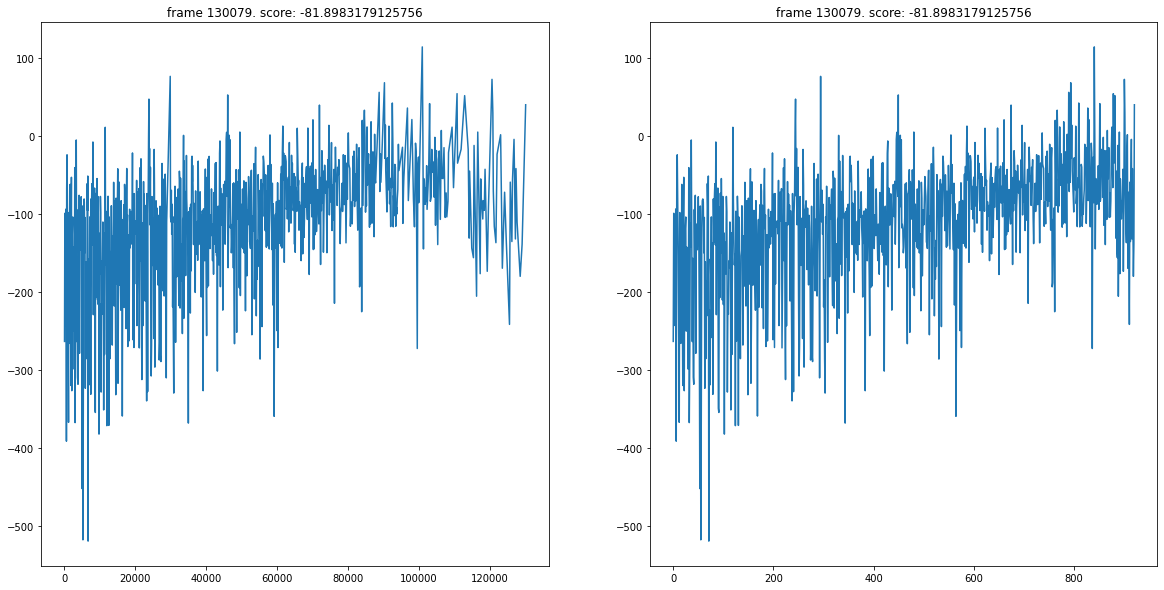

In [ ]:
env_lists = ['CartPole-v0', 'LunarLander-v2']
env_name = env_lists[1]
gamma = 0.995

buffer_size = 3000 # Replay Buffer 사이즈 # cartpole
buffer_size = 150000 # Replay Buffer 사이즈 # lunarlander
batch_size = 32    # Replay Buffer에서 가지고 올 샘플 개수
env = gym.make(env_name)
state_dim = (env.observation_space.shape[0], ) 
        
update_buf_start = 100 # cartpole
update_buf_start = 100 # lunarlander
update_freq = 1
update_target_freq = 100
update_push_freq = 1

epsilon = 1.0
eps_decay = 1/2000  # cartpole
eps_decay = 0.000005 # lunarlander
eps_min = 0.1
hidden = 128 # cartpole
hidden = 256 # lunarlander
learning_rate = 0.001 # cartpole
learning_rate = 0.00002 # lunarlander

device = "cuda:1" if torch.cuda.is_available() else "cpu"
is_wandb = True     # whether to use wandb or not
plot_mode = 'wandb' # plot options: 'wandb' or 'inline'
WANDB_GROUP_NAME = 'Distributed_DQN_' + str(np.random.randint(10000))
actor_idx = 1

params_server = Network_parameter_server() 
memory = ReplayBuffer(buffer_size, state_dim)
actor = Actor(params_server, memory, env_name, actor_idx, gamma, epsilon, eps_decay,
            eps_min, update_freq, update_buf_start, update_target_freq, update_push_freq, hidden,
            learning_rate, batch_size, device, is_wandb, plot_mode, WANDB_GROUP_NAME)
actor.train()